In [274]:
from pyforest import *
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
warnings.filterwarnings('ignore')
lazy_imports()

['from sklearn.preprocessing import PolynomialFeatures',
 'import bokeh',
 'import pickle',
 'from sklearn.linear_model import LinearRegression',
 'from sklearn.model_selection import KFold',
 'from sklearn.manifold import TSNE',
 'from sklearn.linear_model import Lasso',
 'from sklearn.decomposition import PCA',
 'import xgboost as xgb',
 'import skimage',
 'import sklearn',
 'from sklearn.model_selection import GridSearchCV',
 'from openpyxl import load_workbook',
 'import dash',
 'from sklearn.linear_model import ElasticNetCV',
 'from sklearn.preprocessing import RobustScaler',
 'from sklearn.ensemble import GradientBoostingRegressor',
 'from sklearn.linear_model import RidgeCV',
 'from sklearn.feature_extraction.text import CountVectorizer',
 'import statsmodels.api as sm',
 'from sklearn.ensemble import RandomForestClassifier',
 'from scipy import stats',
 'from sklearn.linear_model import ElasticNet',
 'from sklearn import svm',
 'from sklearn.preprocessing import MinMaxScaler',


In [275]:
# read dataset
df_covid = pd.read_csv('dataset/imputed-data.csv',header = 0)
df_covid.head()

<IPython.core.display.Javascript object>

,date,county_fips,county_name,state_fips,state_name,covid_19_confirmed_cases,covid_19_deaths,social_distancing_total_grade,social_distancing_visitation_grade,social_distancing_encounters_grade,...,age_55_59,age_60_64,age_65_69,age_70_74,age_75_79,age_80_84,age_85_or_higher,immigrant_student_ratio,death_ratio,population_ratio_in_state
0,2020/01/22,1003,Baldwin County,1,Alabama,0.0,0.0,F,F,F,...,7,7,6,4,3,2,2,0.021048,0.010811,4.46047
1,2020/01/23,1003,Baldwin County,1,Alabama,0.0,0.0,F,F,F,...,7,7,6,4,3,2,2,0.021048,0.010811,4.46047
2,2020/01/24,1003,Baldwin County,1,Alabama,0.0,0.0,F,F,F,...,7,7,6,4,3,2,2,0.021048,0.010811,4.46047
3,2020/01/25,1003,Baldwin County,1,Alabama,0.0,0.0,F,F,F,...,7,7,6,4,3,2,2,0.021048,0.010811,4.46047
4,2020/01/26,1003,Baldwin County,1,Alabama,0.0,0.0,F,F,F,...,7,7,6,4,3,2,2,0.021048,0.010811,4.46047


In [276]:
# df_informations
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992266 entries, 0 to 992265
Data columns (total 64 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   date                                           992266 non-null  object 
 1   county_fips                                    992266 non-null  int64  
 2   county_name                                    992266 non-null  object 
 3   state_fips                                     992266 non-null  int64  
 4   state_name                                     992266 non-null  object 
 5   covid_19_confirmed_cases                       992266 non-null  float64
 6   covid_19_deaths                                992266 non-null  float64
 7   social_distancing_total_grade                  992266 non-null  object 
 8   social_distancing_visitation_grade             992266 non-null  object 
 9   social_distancing_encounters_grade   

In [277]:
# date as date format
df_covid['date'] = pd.to_datetime(df_covid['date'])
df_covid['date'].head()

<IPython.core.display.Javascript object>

0   2020-01-22
1   2020-01-23
2   2020-01-24
3   2020-01-25
4   2020-01-26
Name: date, dtype: datetime64[ns]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='date', ylabel='covid_19_confirmed_cases'>

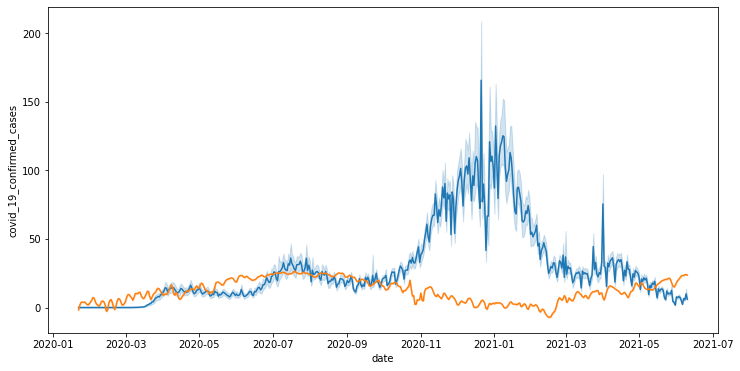

In [278]:
plt.figure(figsize = (12,6))
sns.lineplot(x = 'date', y = 'covid_19_confirmed_cases', data = df_covid)
sns.lineplot(x = 'date', y = 'temperature', data = df_covid)

In [279]:
# top high POPULATED counties
high_case = df_covid[df_covid['date'] == '2020-02-01'].groupby(['state_name'])[
    'total_population'].sum().sort_values(ascending = False)
high_case_10 = list(high_case.index[:10])
high_case_10

['California',
 'Texas',
 'Florida',
 'New York',
 'Pennsylvania',
 'Illinois',
 'North Carolina',
 'Ohio',
 'Michigan',
 'New Jersey']

In [280]:
# top low POPULATED counties
low_case = df_covid[df_covid['date'] == '2020-02-01'].groupby(['state_name'])[
    'total_population'].sum().sort_values(ascending = True)
low_case_10 = list(low_case.index[:10])
low_case_10

['Wyoming',
 'Vermont',
 'North Dakota',
 'South Dakota',
 'Montana',
 'Delaware',
 'Rhode Island',
 'Maine',
 'New Hampshire',
 'West Virginia']

In [281]:
# feature engineering
df_covid['median_household_income_bins'] = pd.qcut(df_covid['median_household_income'],q = 5).cat.codes
df_covid['smoker_bins'] = pd.qcut(df_covid['percent_of_smokers'],q = 13).cat.codes
df_covid['diabetes_bins'] = pd.qcut(df_covid['percent_of_diabetes'],q = 7).cat.codes
df_covid['no_of_death'] = df_covid['death_ratio']*df_covid['total_population']
df_covid['no_of_student_immigrants'] = df_covid['immigrant_student_ratio']*df_covid['total_population']
df_covid['social_distancing_total_grade'] = LabelEncoder().fit_transform(df_covid['social_distancing_total_grade'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [282]:
# top states filter
top_states = df_covid[df_covid['state_name'].isin(high_case_10)]
top_states = top_states.groupby(['state_fips','state_name','date'])[['total_population','number_of_meat_plants',
                                    'no_of_death','covid_19_confirmed_cases', 'daily_state_test','virus_pressure',
                                       'no_of_student_immigrants','airport_distance']].mean().reset_index()
top_states.head()

,state_fips,state_name,date,total_population,number_of_meat_plants,no_of_death,covid_19_confirmed_cases,daily_state_test,virus_pressure,no_of_student_immigrants,airport_distance
0,6,California,2020-01-22,730506.907407,12.611111,4959.259774,0.000000,1.0,0.000000,15321.5,94.495167
1,6,California,2020-01-23,730506.907407,12.611111,4959.259774,0.000000,1.0,0.000000,15321.5,94.495167
2,6,California,2020-01-24,730506.907407,12.611111,4959.259774,0.000000,0.0,0.000000,15321.5,94.495167
3,6,California,2020-01-25,730506.907407,12.611111,4959.259774,0.000000,0.0,0.000000,15321.5,94.495167
4,6,California,2020-01-26,730506.907407,12.611111,4959.259774,0.037037,0.0,0.032253,15321.5,94.495167


In [283]:
# create individual df for states
state_df = {}
state_ts = {}
for state in high_case_10:
    state_df[state] = pd.DataFrame(data = top_states[top_states['state_name'] == state])
    state_df[state] = state_df[state][['date','total_population','number_of_meat_plants',
                                    'no_of_death','covid_19_confirmed_cases','virus_pressure',
                                       'no_of_student_immigrants','airport_distance']].resample('D', on='date').mean()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [284]:
# testing dfs
state_df['California'].head()

,total_population,number_of_meat_plants,no_of_death,covid_19_confirmed_cases,virus_pressure,no_of_student_immigrants,airport_distance
date,,,,,,,
2020-01-22,730506.907407,12.611111,4959.259774,0.000000,0.000000,15321.5,94.495167
2020-01-23,730506.907407,12.611111,4959.259774,0.000000,0.000000,15321.5,94.495167
2020-01-24,730506.907407,12.611111,4959.259774,0.000000,0.000000,15321.5,94.495167
2020-01-25,730506.907407,12.611111,4959.259774,0.000000,0.000000,15321.5,94.495167
2020-01-26,730506.907407,12.611111,4959.259774,0.037037,0.032253,15321.5,94.495167


<AxesSubplot:xlabel='date'>

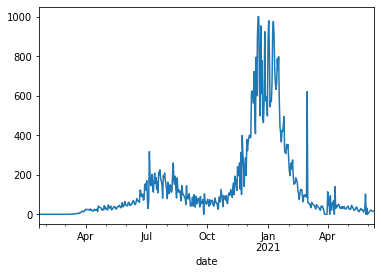

In [285]:
state_df['California']['covid_19_confirmed_cases'].plot()

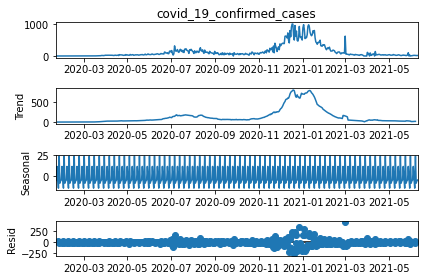

In [286]:
# check seasonal decompose
result = seasonal_decompose(state_df['California']['covid_19_confirmed_cases'],model = 'add')
result.plot();

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='date'>

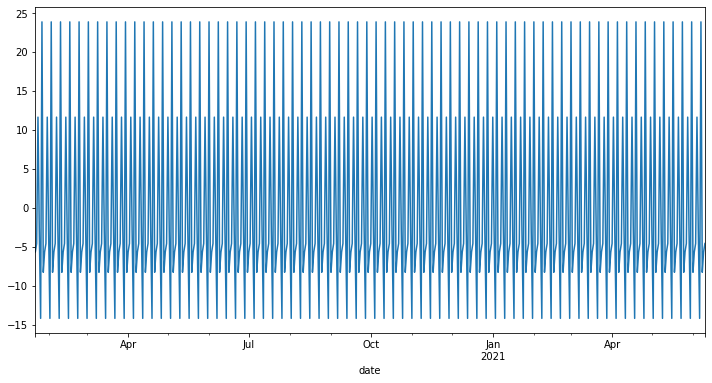

In [287]:
plt.figure(figsize = (12,6))
result.seasonal.plot()

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='date'>

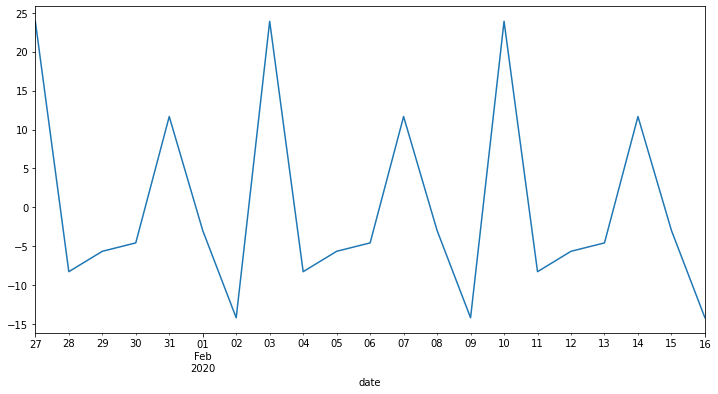

In [288]:
plt.figure(figsize = (12,6))
result.seasonal[5:26].plot()

In [289]:
# train test split
from sklearn.model_selection import train_test_split

train_df = {}
test_df = {}
future_df = {}

for state in high_case_10:
#     X_train,X_test,y_train,y_test = train_test_split(state_df[state].loc[:,
#                                                     ~state_df[state].columns.isin(['covid_19_confirmed_cases','date'])],
#                                             state_df[state]['covid_19_confirmed_cases'],test_size = 0.4,shuffle = False,
#                                                      stratify = None)

    train = state_df[state][state_df[state].index <= '2020-12-31']
    test = state_df[state][(state_df[state].index > '2020-12-31')]

    train_df[state] = train
    test_df[state] = test

<AxesSubplot:xlabel='date'>

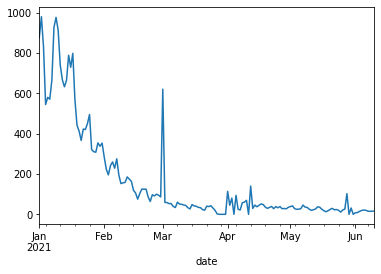

In [290]:
test_df['California']['covid_19_confirmed_cases'].plot()

In [291]:
# checking for each states forecast range
for state in high_case_10:
    print(state , " : whole : ", len(state_df[state].index))
    print(state , " : train : ", len(train_df[state].index))
    print(state , " : test : ", len(test_df[state].index))

California  : whole :  506
California  : train :  345
California  : test :  161
Texas  : whole :  506
Texas  : train :  345
Texas  : test :  161
Florida  : whole :  506
Florida  : train :  345
Florida  : test :  161
New York  : whole :  506
New York  : train :  345
New York  : test :  161
Pennsylvania  : whole :  506
Pennsylvania  : train :  345
Pennsylvania  : test :  161
Illinois  : whole :  506
Illinois  : train :  345
Illinois  : test :  161
North Carolina  : whole :  506
North Carolina  : train :  345
North Carolina  : test :  161
Ohio  : whole :  506
Ohio  : train :  345
Ohio  : test :  161
Michigan  : whole :  506
Michigan  : train :  345
Michigan  : test :  161
New Jersey  : whole :  506
New Jersey  : train :  345
New Jersey  : test :  161


In [292]:
train_df['California'].columns

Index(['total_population', 'number_of_meat_plants', 'no_of_death',
       'covid_19_confirmed_cases', 'virus_pressure',
       'no_of_student_immigrants', 'airport_distance'],
      dtype='object')

In [293]:
# auto_arima fit #c
from pmdarima import auto_arima
grid_model = {}
for state in high_case_10:
    grid_model[state] = auto_arima(state_df[state]['covid_19_confirmed_cases'],
                        exogenous = state_df[state][['total_population', 'number_of_meat_plants', 'no_of_death',
       'virus_pressure', 'no_of_student_immigrants',
       'airport_distance']],seasonal = True,m = 7,trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=6168.853, Time=0.16 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=inf, Time=nan sec

Best model:  ARIMA(0,0,0)(0,0,0)[7]          
Total fit time: 0.191 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=inf, Time

In [294]:
for state in high_case_10:
    print(grid_model[state].summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  506
Model:                        SARIMAX   Log Likelihood               -3077.426
Date:                Sun, 03 Apr 2022   AIC                           6168.853
Time:                        20:55:59   BIC                           6198.439
Sample:                    01-22-2020   HQIC                          6180.456
                         - 06-10-2021                                         
Covariance Type:                  opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
total_population         -3.632e-06      0.000     -0.009      0.993      -0.001       0.001
number_of_meat_plants     -6.27e-11   7.34e-09     -0.009      0.993   -1.45e-08    1.43e

In [295]:
# sarimax model 
ts_model = {}
for state in high_case_10:
    ts_model[state] = SARIMAX(train_df[state]['covid_19_confirmed_cases'],
                        exog = train_df[state].loc[:,
                                             ~train_df[state].columns.isin(['covid_19_confirmed_cases'])],
                   order = (0,0,0), seasonal_order = (0,0,0,7)).fit()
    print(ts_model[state].summary())

                                  SARIMAX Results                                   
Dep. Variable:     covid_19_confirmed_cases   No. Observations:                  345
Model:                              SARIMAX   Log Likelihood               -2050.218
Date:                      Sun, 03 Apr 2022   AIC                           4114.436
Time:                              20:55:59   BIC                           4141.341
Sample:                          01-22-2020   HQIC                          4125.151
                               - 12-31-2020                                         
Covariance Type:                        opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
total_population         -2.543e-06      0.000     -0.007      0.995      -0.001       0.001
number_of_meat_plants    -4.391e-11   6.4

                                  SARIMAX Results                                   
Dep. Variable:     covid_19_confirmed_cases   No. Observations:                  345
Model:                              SARIMAX   Log Likelihood               -1654.873
Date:                      Sun, 03 Apr 2022   AIC                           3323.746
Time:                              20:55:59   BIC                           3350.651
Sample:                          01-22-2020   HQIC                          3334.461
                               - 12-31-2020                                         
Covariance Type:                        opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
total_population         -8.743e-07      0.001     -0.001      0.999      -0.001       0.001
number_of_meat_plants     -2.98e-11   2.1

                                  SARIMAX Results                                   
Dep. Variable:     covid_19_confirmed_cases   No. Observations:                  345
Model:                              SARIMAX   Log Likelihood               -1864.941
Date:                      Sun, 03 Apr 2022   AIC                           3743.883
Time:                              20:56:00   BIC                           3770.787
Sample:                          01-22-2020   HQIC                          3754.597
                               - 12-31-2020                                         
Covariance Type:                        opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
total_population          -2.05e-05      0.001     -0.024      0.981      -0.002       0.002
number_of_meat_plants    -4.499e-10   1.8

In [296]:
# forecast first
forecast = {}
for state in high_case_10:
    forecast_temp = ts_model[state].forecast(steps = 161,exog = test_df[state].iloc[:161,
                                             ~test_df[state].columns.isin(['covid_19_confirmed_cases'])],
            typ = 'levels').rename('forecast_sarimax')
    forecast[state] = pd.DataFrame(forecast_temp)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [297]:
forecast['California']

,forecast_sarimax
2021-01-01,866.624681
2021-01-02,943.902936
2021-01-03,813.285561
2021-01-04,515.471568
2021-01-05,563.718630
...,...
2021-06-06,18.356572
2021-06-07,17.947466
2021-06-08,15.308946
2021-06-09,15.735490


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='date', ylabel='covid_19_confirmed_cases'>

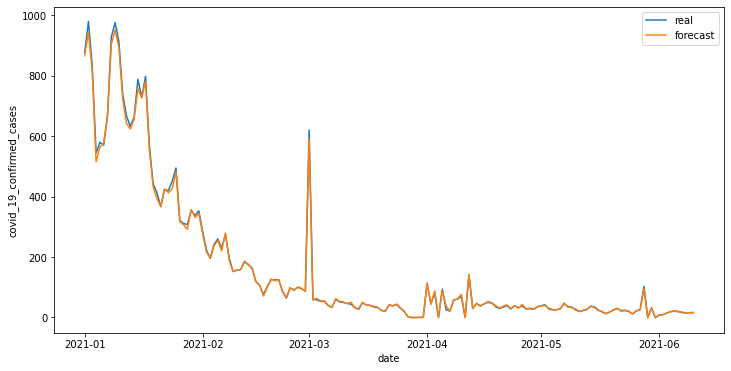

In [298]:
#forecast plot
plt.figure(figsize = (12,6))
sns.lineplot(x = test_df['California'].iloc[:161].index,
             y = test_df['California'].iloc[:161]['covid_19_confirmed_cases'],label = 'real'
             ,legend = True)
sns.lineplot(x = forecast['California'].index, y = forecast['California']['forecast_sarimax'],label = 'forecast')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='date', ylabel='covid_19_confirmed_cases'>

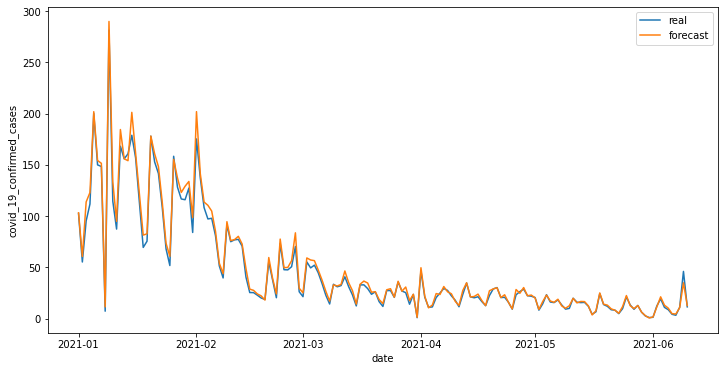

In [299]:
#forecast plot
plt.figure(figsize = (12,6))
sns.lineplot(x = test_df['Texas'].iloc[:161].index,
             y = test_df['Texas'].iloc[:161]['covid_19_confirmed_cases'],label = 'real'
             ,legend = True)
sns.lineplot(x = forecast['Texas'].index, y = forecast['Texas']['forecast_sarimax'],label = 'forecast')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='date', ylabel='covid_19_confirmed_cases'>

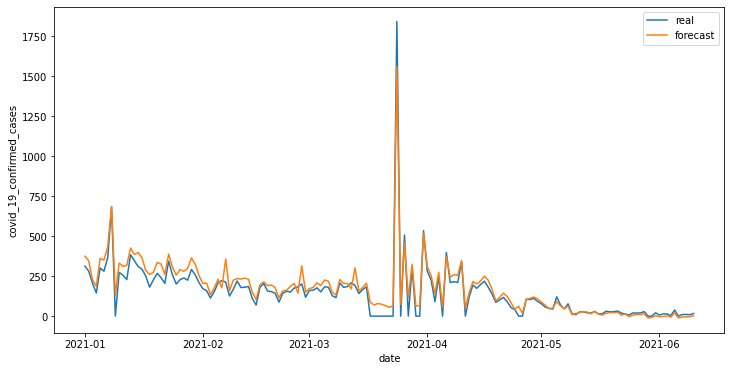

In [300]:
#forecast plot
plt.figure(figsize = (12,6))
sns.lineplot(x = test_df['New Jersey'].iloc[:161].index,
             y = test_df['New Jersey'].iloc[:161]['covid_19_confirmed_cases'],label = 'real'
             ,legend = True)
sns.lineplot(x = forecast['New Jersey'].index, y = forecast['New Jersey']['forecast_sarimax'],label = 'forecast')

In [301]:
# evaluating
np.sqrt(metrics.mean_squared_error(test_df['Texas'].iloc[:161]['covid_19_confirmed_cases']
                                   ,forecast['Texas']['forecast_sarimax']))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

5.573761320977733

In [302]:
test_df['Texas'].iloc[:161]['covid_19_confirmed_cases'].mean() # 12 % error

47.63604952490642

In [303]:
np.sqrt(metrics.mean_squared_error(test_df['California'].iloc[:161]['covid_19_confirmed_cases']
                                   ,forecast['California']['forecast_sarimax'])) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

8.067311281471104

In [304]:
test_df['California'].iloc[:161]['covid_19_confirmed_cases'].mean() # 6% error

166.1506786289395